In [2]:
import torch as tc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(r'../') #path to folder where file that stored the results is located

In [3]:
run = "./run_lin_regression/"

In [4]:
with open(run + "graphical_model.pkl", "rb") as f:
    model = pickle.load(f)
    
proposal_samples = tc.load(run + "proposal_samples.pt").numpy() #latent topological order
proposal_weights = tc.load(run + "proposal_weights.pt").numpy()
proposal_weights /= proposal_weights.sum()
idx = np.random.choice(np.arange(len(proposal_weights)), size=len(proposal_weights), p=proposal_weights)
resamples = proposal_samples[idx]

df1 = pd.DataFrame(proposal_samples, columns = ["slope", "bias"]) #CHANGE : PUT TOPOLOGICAL ORDER INSTEAD
df1["sample_type"] = ["proposal"]*len(idx)
df1["color"] = ["orange"]*len(idx)
df2 = pd.DataFrame(resamples, columns = ["slope", "bias"])
df2["sample_type"] = ["posterior"]*len(idx)
df2["color"] = ["blue"]*len(idx)
df = pd.concat([df1, df2], axis=0)

In [5]:
def triangle_plot(df, **kwargs):
    n = len(df.columns) - 2 #-2 because 1 col for color, one for type
    fig, axs = plt.subplots(n,n, **kwargs)
    for i in range(n):
        for j in range(n):
            if i==j:
                axs[i,j].hist(df[df["sample_type"]=="proposal"][df.columns[i]], bins="auto", alpha=0.4, label="proposal")
                axs[i,j].hist(df[df["sample_type"]=="posterior"][df.columns[i]], bins="auto", alpha=0.4, label="posterior")
                axs[i,j].legend()
            elif i>j:
                axs[i,j].scatter(df[df["sample_type"]=="proposal"][df.columns[i]], df[df["sample_type"]=="proposal"][df.columns[j]], s=10, alpha=0.5, label="proposal")
                axs[i,j].scatter(df[df["sample_type"]=="posterior"][df.columns[i]], df[df["sample_type"]=="posterior"][df.columns[j]],s=10, alpha=0.5, label="posterior")
                axs[i,j].legend()
            else:
                axs[i,j].set_axis_off()


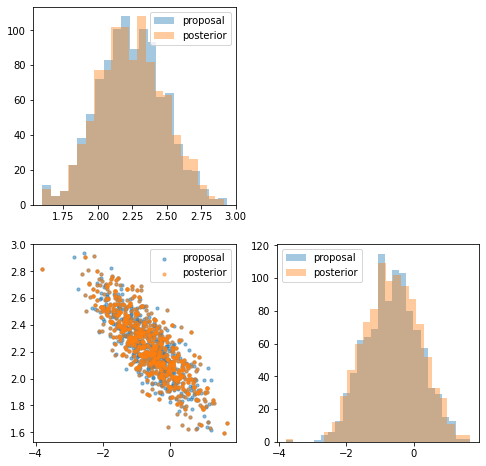

In [6]:
triangle_plot(df, figsize=(8,8))

In [13]:
observed = []
for var in model.topological():
    if var in model.Graph["Y"].keys():
        observed.append(tc.tensor(model.Graph["Y"][var]).float())

observed = tc.stack(observed)

observed_test = np.random.normal(3 * np.arange(6) + 10, scale = 0.1)
observed_test = tc.tensor(observed_test[observed.argsort().argsort()]).float()

In [14]:
def plot_proposal_by_epochs(epochs : int, observed : tc.Tensor, model, num_samples = 2000, **kwargs):
    
    latents = [var for var in model.topological() if var.startswith("sample")]
    fig, axs = plt.subplots(2, epochs, **kwargs)
    
    for i, latent in enumerate(latents):
        for epoch in range(epochs):
            with open(run + "proposal_epoch{}.pkl".format(epoch), "rb") as f:
                proposal = pickle.load(f)
            
            proposal_samples = []
            for _ in range(num_samples):
                sample = proposal.sample(y = observed)[latent]
                proposal_samples.append(sample)

            proposal_samples = tc.stack(proposal_samples).numpy()
            axs[i,epoch].hist(proposal_samples, bins="auto", label="epoch {}".format(epoch))
            axs[i,epoch].legend()

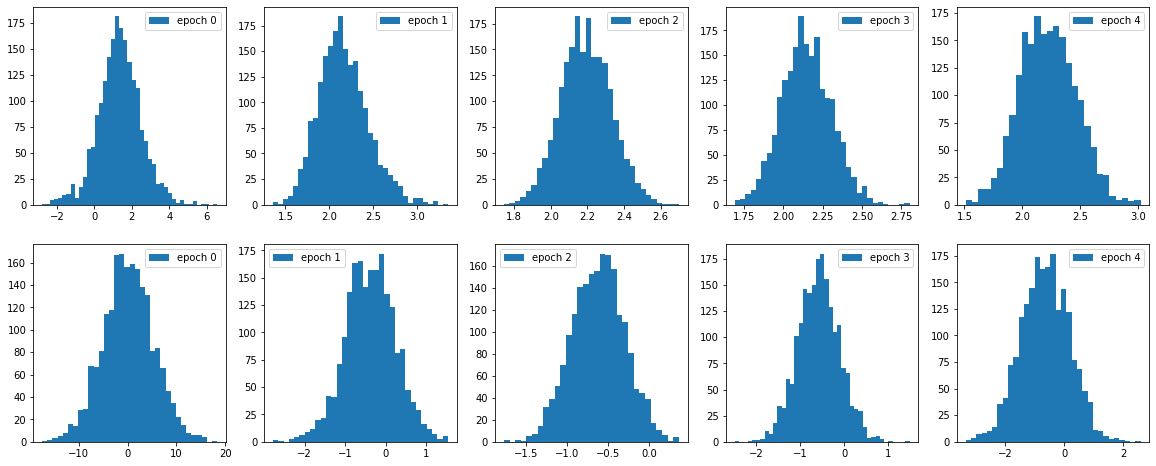

In [11]:
plot_proposal_by_epochs(epochs=5, observed=observed, model=model, figsize=(20,8))

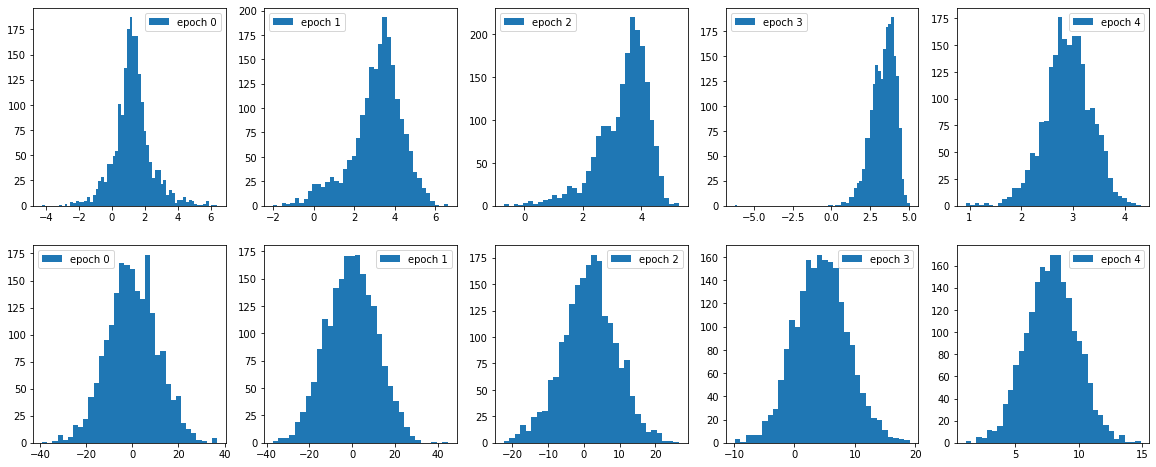

In [15]:
plot_proposal_by_epochs(epochs=5, observed=observed_test, model=model, figsize=(20,8))

In [9]:
def plot_losses(**kwargs):
    losses = tc.load(run + "losses.pt")
    fig, axs = plt.subplots(1, len(losses), **kwargs)
    for i, loss in enumerate(losses):
        axs[i].plot(loss, label="epoch {}".format(i))
        axs[i].legend()
    return


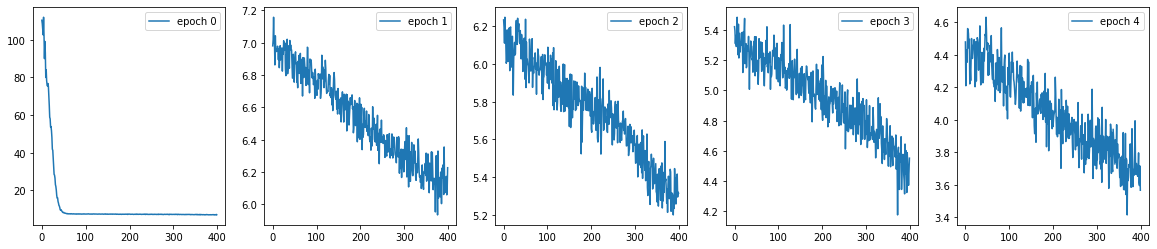

In [10]:
plot_losses(figsize=(20,4))